In [1]:
import requests
from dateutil import parser
import time
import io
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

BASE_URL = "https://finance.yahoo.com/quote/{ticker}/history"
CSV_URL = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start}&period2={end}&interval=1d&events=history&crumb={crumb}"

MAX_ATTEMPTS = 3

def get_stock_prices(tickers, startDate, endDate):
    """
    Returns a Pandas DataFrame containing the daily HLOC and adjusted close for TICKER from STARTDATE to ENDDATE.
    """
    try:
        start_time = parser.parse(startDate)
        end_time = parser.parse(endDate)
    except:
        print("Error: Could not parse date given. Please input date as a string, e.g., '2017-03-30', or '2017/3/30', etc.")
        return
        
    start_epoch = int(time.mktime(start_time.timetuple()))
    end_epoch = int(time.mktime(end_time.timetuple()))
    
    if start_epoch > end_epoch:
        print("Error: Start date must be before end date")
        return
    
    tickers = [ticker.upper() for ticker in tickers]
    
    attempts = 0
    success = False
    
    start = time.time()
    while (not success):
        try:
            panel = _get_panel(start_epoch, end_epoch, tickers)
            success = True
        except:
            attempts += 1
            if attempts >= MAX_ATTEMPTS:
                print("Error: Could not access Yahoo Finance data after %d attempts." % MAX_ATTEMPTS)
                break
            continue
        
    end = time.time()
        
    print("Succeeded in %.2fs after %d attempts" % (end - start, attempts + 1))
    
    return panel

def _get_panel(start_epoch, end_epoch, tickers):
    with requests.Session() as s:
        r = s.get(BASE_URL.format(ticker=tickers[0]))
        soup = BeautifulSoup(r.content, 'html.parser')
        html = soup.prettify()
        crumb_start = html.find("CrumbStore") + 22
        crumb_end = crumb_start + html[crumb_start: crumb_start + 30].find('\"')
        crumb = soup.prettify()[crumb_start:crumb_end]
        
        df_dict = {column: pd.DataFrame() for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']}
        
        for ticker in tickers:
            csv = s.get(CSV_URL.format(ticker=ticker, start=start_epoch, end=end_epoch, crumb=crumb)).content
            df = pd.read_csv(io.StringIO(csv.decode('utf-8')), index_col=0)
            
            for column in df_dict.keys():
                column_df = df_dict[column]
                column_df[ticker] = df[column]
                df_dict[column] = column_df
                
        full_panel = pd.Panel(df_dict)
        
    return full_panel


In [3]:
spy = get_stock_prices(['SPY'], '2002-01-01', '2018-03-05')

Succeeded in 1.16s after 1 attempts


In [4]:
prices = spy['Adj Close']
prices_shifted = np.array(prices[61:])
prices_base = np.array(prices[:-61])
print(len(prices_base), len(prices_shifted))

4010 4010


In [5]:
rets = pd.Series(index = prices.index[61:], data=((prices_shifted - prices_base)/prices_base).flatten())

/Users/Badre/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=60).mean()
  from ipykernel import kernelapp as app


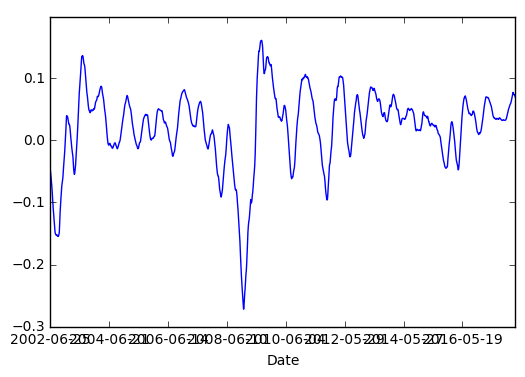

In [6]:
%matplotlib inline
pd.rolling_mean(rets, 60).dropna().plot()

In [35]:
print(np.mean(rets))
print(np.std(rets))

0.021165928285749112
0.07525039445055202


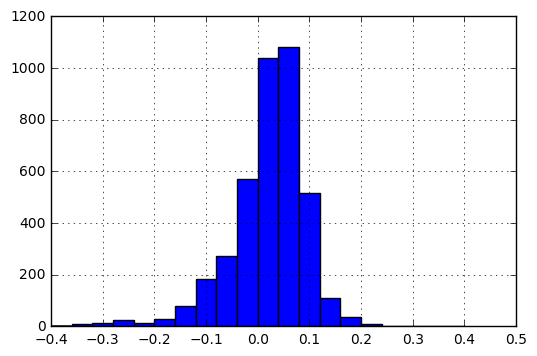

In [46]:
rets.hist(bins=20, range=(-0.4, 0.4))

In [49]:
rets.quantile(q=0.975)

0.13912661002635313

In [70]:
ff = pd.read_csv('FRED-FEDFUNDS.csv', index_col=0)[::-1].loc['2001-09-01':, :]

In [72]:
ff_shifted = np.array(ff[3:])
ff_base = np.array(ff[:-3])
print(len(ff_base), len(ff_shifted))

195 195


In [73]:
delta = pd.Series(index = ff.index[3:], data=((ff_shifted - ff_base)/ff_base).flatten())

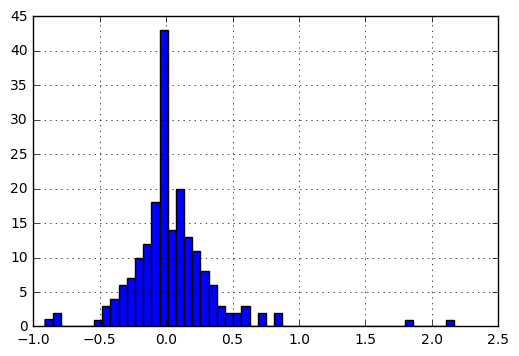

In [78]:
delta.hist(bins=50)

In [85]:
print(np.median(delta))
print(np.std(delta))

0.00190476190476
0.3286526499065992


In [94]:
cleaned = delta[abs(delta - np.mean(delta)) < 0.5 * np.std(delta)]

In [97]:
print(np.mean(cleaned))
print(np.std(cleaned))

0.028528006344510925
0.08031379611117706


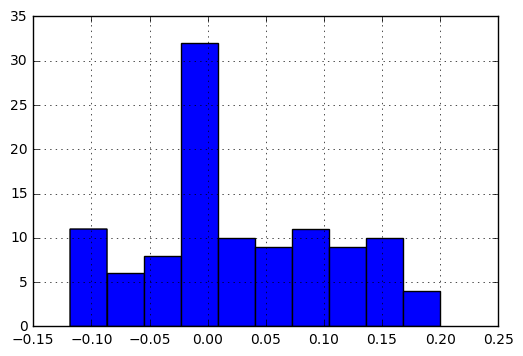

In [98]:
cleaned.hist()

In [100]:
bonds = pd.read_csv('FRED-DGS10.csv', index_col=0)[::-1].loc['2001-09-01':, :]
bonds.head()

,Value
Date,
2001-09-04,4.99
2001-09-05,4.97
2001-09-06,4.86
2001-09-07,4.80
2001-09-10,4.84


In [110]:
def df_metrics(df, window = 60, bins = 30):
    shifted = np.array(df[window:])
    base = np.array(df[:-1*window])
    deltas = pd.Series(index = df.index[window:], data=((shifted - base)/base).flatten())
    print("Mean: ", np.mean(deltas))
    print("SD: ", np.std(deltas))
    deltas.hist(bins=bins)
    return deltas

Mean:  0.0020386604639388226
SD:  0.1467733607224801


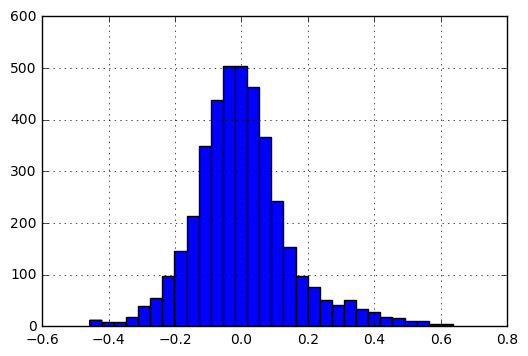

In [111]:
deltas = df_metrics(bonds)

/Users/Badre/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=60).mean()
  if __name__ == '__main__':


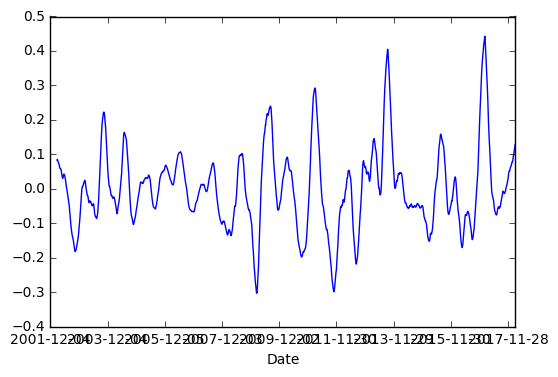

In [112]:
pd.rolling_mean(deltas, window = 60).plot()

In [2]:
vix = get_stock_prices(['^VIX'], '1980-01-01', '2018-03-05')

Succeeded in 1.19s after 1 attempts


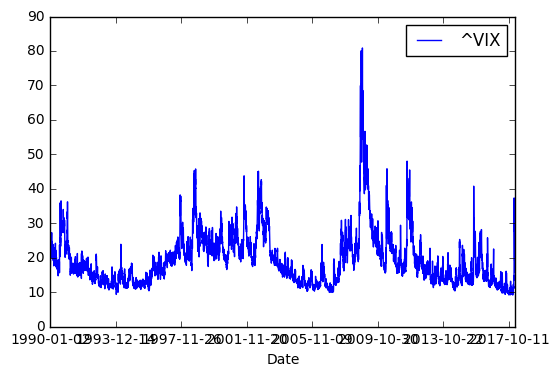

In [7]:
vix['Adj Close'].plot()

In [8]:
asian_crisis_vix = get_stock_prices(['^VIX'], '1997-04-01', '1997-08-05')

Succeeded in 0.74s after 1 attempts


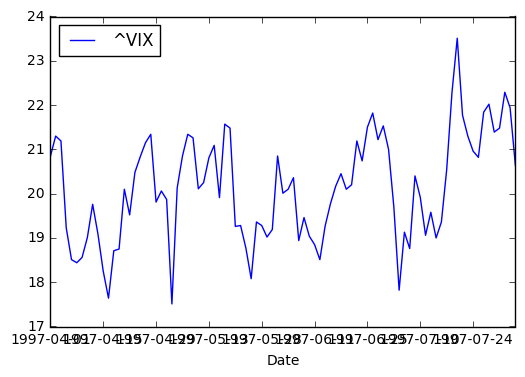

In [9]:
asian_crisis_vix['Adj Close'].plot()

Succeeded in 0.70s after 1 attempts


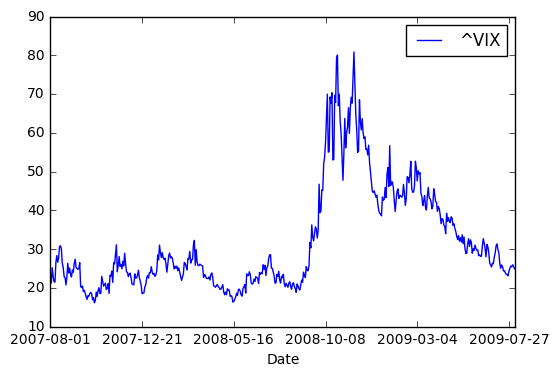

In [11]:
rec_vix = get_stock_prices(['^VIX'], '2007-08-01', '2009-08-05')['Adj Close'].plot()